In [1]:
import os
import math
import random

import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [14]:
import sys
sys.path.insert(0, '/sbox/users/blake/projects/SSD-Tensorflow/')

In [17]:
import visualization

In [18]:
from nets import ssd_vgg_300, ssd_common, np_methods
from preprocessing import ssd_vgg_preprocessing
import visualization

In [19]:
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)

## SSD 300 Model

The SSD 300 network takes 300x300 image inputs. In order to feed any image, the latter is resize to this input shape (i.e.`Resize.WARP_RESIZE`). Note that even though it may change the ratio width / height, the SSD model performs well on resized images (and it is the default behaviour in the original Caffe implementation).

SSD anchors correspond to the default bounding boxes encoded in the network. The SSD net output provides offset on the coordinates and dimensions of these anchors.

In [20]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)

# Restore SSD model.
ckpt_filename = '../checkpoints/ssd_300_vgg.ckpt'
# ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

INFO:tensorflow:Restoring parameters from ../checkpoints/ssd_300_vgg.ckpt


## Post-processing pipeline

The SSD outputs need to be post-processed to provide proper detections. Namely, we follow these common steps:

* Select boxes above a classification threshold;
* Clip boxes to the image shape;
* Apply the Non-Maximum-Selection algorithm: fuse together boxes whose Jaccard score > threshold;
* If necessary, resize bounding boxes to original image shape.

In [68]:
# Main image processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=.45, net_shape=(300, 300)):
    # Run SSD network.
    s = time.time()
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    e = time.time()
    print e-s
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    print time.time()-e
    return rclasses, rscores, rbboxes

0.0277411937714
0.0046718120575


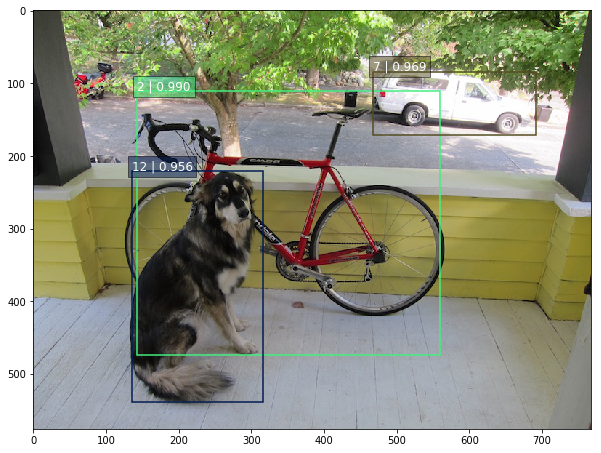

In [69]:
# Test on some demo image and visualize output.
path = '../demo/'
image_names = sorted(os.listdir(path))

img = mpimg.imread(path + image_names[-5])
rclasses, rscores, rbboxes =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

In [81]:
# Test on some demo image and visualize output.
import time
import glob
image_files =  glob.glob('/sbox/data/2017/03/05/22/51/4*/cameras/cam3/images/*')
times = []
#image_files = ['/tmp/car.jpg']
for image_file in image_files:
    img = mpimg.imread(image_file)
#    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    start = time.time()
    rclasses, rscores, rbboxes =  process_image(img)
    end = time.time()
    print 1/(end-start)
    times.append(end-start)
#     visualization.plt_bboxes(img, rclasses, rscores, rbboxes)
print np.mean(times)
# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)


0.0193130970001
0.00404286384583
42.5640494819
0.0182859897614
0.00285506248474
46.9130036015
0.0175929069519
0.00260806083679
49.1130548823
0.0174560546875
0.00241899490356
49.903080346
0.0182611942291
0.00360894203186
45.3227580692
0.0179588794708
0.00368404388428
45.802345644
0.018532037735
0.00437998771667
43.2246508992
0.0181770324707
0.00318503379822
46.5351262593
0.0181300640106
0.00300407409668
47.1143062545
0.0173001289368
0.00295782089233
48.8783955437
0.0171020030975
0.00282311439514
49.7733896616
0.0179808139801
0.00380396842957
45.6309319176
0.0180439949036
0.00383186340332
45.2547851794
0.0178339481354
0.00316500663757
47.398085681
0.0182671546936
0.00416088104248
44.3574140466
0.0182278156281
0.00400400161743
44.7287463209
0.0183711051941
0.00382995605469
44.6212047065
0.0184388160706
0.00432205200195
43.6433863315
0.0178110599518
0.00409698486328
45.158798006
0.0182259082794
0.00385904312134
45.036604353
0.0176758766174
0.00397205352783
45.9327594892
0.0178990364075
0.0

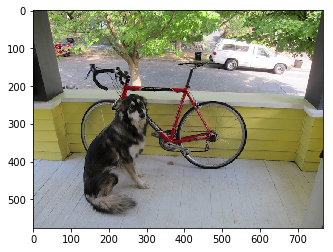

In [60]:
rclasses

array([ 2,  7, 12])

In [84]:
range(100)[::10]

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]